<a id="1"></a>
# <div style="border: 2px solid #555; color:black; border-radius: 10px; background-color: #0074D9; padding: 10px; font-size: 20px; text-align: center;">Introduction</div>

**Table Of Content:**
* [Introduction](#1)
* [Import data and preprocess](#2)
* [Split Train-Eval](#3)
* [Define Model and Train](#4)
* [Submission](#5)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
from datasets import Dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
import torch.nn.functional as F
from IPython.display import display
import wandb
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<a id="2"></a>
# <div style="border: 2px solid #555; color:black; border-radius: 10px; background-color: #0074D9; padding: 10px; font-size: 20px; text-align: center;">Import data and preprocess</div>
* [return top](#1)

In [2]:
run = wandb.init(
    project="h2o-ai-predict-the-llm-kaggle-competition", 
    entity=None, 
   job_type="data_split"
)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [3]:
raw_data_at = run.use_artifact('mustafakeser/h2o-ai-predict-the-llm-kaggle-competition/detect_llm_raw_data:v1', 
                               type='raw_data')
artifact_dir = raw_data_at.download()

wandb:   4 of 4 files downloaded.  


In [4]:
import json
with open("/kaggle/working/artifacts/detect_llm_raw_data:v1/train_df.table.json") as json_data:
    data = json.load(json_data)
    train = pd.DataFrame(data = data["data"],columns=data["columns"])
    json_data.close()

In [5]:
with open("/kaggle/working/artifacts/detect_llm_raw_data:v1/test_df.table.json") as json_data:
    data = json.load(json_data)
    test = pd.DataFrame(data = data["data"],columns=data["columns"])
    json_data.close()

In [6]:
train.head(3)

,Question,Response,target
0,Explain the concept of coevolution.,Coevolution is a biological process that occur...,3
1,Is it possible that recurring fever and chills...,"Yes, recurring fever and chills can be a sympt...",4
2,Evaluate the expression 3!,The expression 3! represents the factorial of ...,1


In [7]:
test.head(3)

,Question,Response
0,Multiply 13 by 7.,Multiplying 13 by 7 gives a result of 64.\nThe...
1,Who were the main protagonists in the Hundred ...,The most important characters in this war incl...
2,What was the importance of the Truman Doctrine?,"The Truman Doctrine, also known as the United ..."


In [8]:
train.fillna(" ",inplace=True)
test.fillna(" ",inplace=True)
train["ques_resp"] = train["Question"].apply(lambda x : x.lower()) + " " + train["Response"].apply(lambda x : x.lower())
test["ques_resp"] = test["Question"].apply(lambda x : x.lower()) + " " + test["Response"].apply(lambda x : x.lower())
df_train = train[["target","ques_resp"]]
df_test = test[["ques_resp"]]

In [9]:
dataset2 = Dataset.from_pandas(df_train)
display(dataset2)
dataset_test = Dataset.from_pandas(df_test)
display(dataset_test)

Dataset({
    features: ['target', 'ques_resp'],
    num_rows: 3976
})

Dataset({
    features: ['ques_resp'],
    num_rows: 1001
})

In [10]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
def tokenize_function(examples):
    return tokenizer(examples["ques_resp"], padding="max_length", truncation=True)
tokenized_datasets2 = dataset2.map(tokenize_function, batched=True)
tokenized_dataset_test = dataset_test.map(tokenize_function, batched=True)

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

<a id="3"></a>
# <div style="border: 2px solid #555; color:black; border-radius: 10px; background-color: #0074D9; padding: 10px; font-size: 20px; text-align: center;">Split Train-Eval</div>
* [return top](#1)

In [11]:
from sklearn.model_selection import StratifiedKFold

In [12]:
#we only get idxs for Fold 0
kf= StratifiedKFold(n_splits=10,shuffle=True,random_state=42)
for i , (tr_idx,val_idx) in enumerate(kf.split(train,train.target)):
    print(f"Fold : {i}")
    print(f"shape train : {tr_idx.shape}")
    print(f"shape val : {val_idx.shape}")
    break

Fold : 0
shape train : (3578,)
shape val : (398,)


In [24]:
split_train_dataset = tokenized_datasets2.select(tr_idx)
split_eval_dataset = tokenized_datasets2.select(val_idx)
display(split_train_dataset)
display(split_eval_dataset2)

Dataset({
    features: ['target', 'ques_resp', 'input_ids', 'attention_mask'],
    num_rows: 3578
})

Dataset({
    features: ['target', 'ques_resp', 'input_ids', 'attention_mask'],
    num_rows: 398
})

In [14]:
processed_data_at = wandb.Artifact("detect-llm-split-dataset", type="split_data")

In [15]:
df_train     = train.loc[tr_idx]
df_val       = train.loc[val_idx]
tbl_df_train = wandb.Table(data=df_train)
tbl_df_val   = wandb.Table(data=df_val)
wandb.log({"train_df": tbl_df_train})
wandb.log({"test_df": tbl_df_val})
processed_data_at.add(tbl_df_train, "df_train")
processed_data_at.add(tbl_df_val, "df_val")

In [16]:
df_train.head()

,Question,Response,target,ques_resp
0,Explain the concept of coevolution.,Coevolution is a biological process that occur...,3,explain the concept of coevolution. coevolutio...
1,Is it possible that recurring fever and chills...,"Yes, recurring fever and chills can be a sympt...",4,is it possible that recurring fever and chills...
2,Evaluate the expression 3!,The expression 3! represents the factorial of ...,1,evaluate the expression 3! the expression 3! r...
3,What are the roles of different types of RNA i...,1. Messenger RNA (mRNA): mRNA carries genetic ...,3,what are the roles of different types of rna i...
4,What is the role of gene flow in population ge...,Gene flow refers to the movement of individual...,3,what is the role of gene flow in population ge...


In [17]:
run.log_artifact(processed_data_at)
run.finish()

wandb: WARNING Source type is set to 'artifact' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


<a id="4"></a>
# <div style="border: 2px solid #555; color:black; border-radius: 10px; background-color: #0074D9; padding: 10px; font-size: 20px; text-align: center;">Define Model and Train</div>
* [return top](#1)

In [18]:
run = wandb.init( 
    project="h2o-ai-predict-the-llm-kaggle-competition", 
    entity=None, 
    job_type="training"
)

wandb: Currently logged in as: mustafakeser. Use `wandb login --relogin` to force relogin


In [19]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=train.target.nunique())

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
# Specify the GPU device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Move your model to the GPU
model.to(device);

In [21]:
num_train_epochs=10.0
training_args = TrainingArguments(output_dir="test_trainer",
                                  evaluation_strategy="steps",
                                  num_train_epochs=num_train_epochs,
                                  logging_steps=500,
                                     lr_scheduler_type = "linear",
                                  load_best_model_at_end=True, 
                                    metric_for_best_model="eval_loss", 
                                    greater_is_better=False 
                                 )

In [22]:
# Define early stopping
early_stopping = EarlyStoppingCallback(early_stopping_patience=2)

In [25]:
print("Before...")
display(split_train_dataset)
print("After...")
split_train_dataset2 = split_train_dataset.remove_columns(['ques_resp'])
split_train_dataset2 = split_train_dataset2.rename_column("target", "labels")
display(split_train_dataset2)

split_eval_dataset2 = split_eval_dataset.remove_columns(['ques_resp'])
split_eval_dataset2 = split_eval_dataset2.rename_column("target", "labels")
display(split_eval_dataset2)

Before...


Dataset({
    features: ['target', 'ques_resp', 'input_ids', 'attention_mask'],
    num_rows: 3578
})

After...


Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 3578
})

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 398
})

In [26]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=split_train_dataset2,
    eval_dataset=split_eval_dataset2,
    callbacks = [early_stopping],
    tokenizer=tokenizer
)

In [27]:
trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
500,1.693100,1.716997
1000,1.353600,1.577431
1500,1.023700,1.567650
2000,0.657800,1.947070
2500,0.428300,2.196788


TrainOutput(global_step=2500, training_loss=1.0313289489746094, metrics={'train_runtime': 599.6665, 'train_samples_per_second': 59.666, 'train_steps_per_second': 7.471, 'total_flos': 2645609833605120.0, 'train_loss': 1.0313289489746094, 'epoch': 5.58})

<a id="5"></a>
# <div style="border: 2px solid #555; color:black; border-radius: 10px; background-color: #0074D9; padding: 10px; font-size: 20px; text-align: center;">Submission</div>
* [return top](#1)

In [28]:
display(tokenized_dataset_test)
tokenized_dataset_test2 = tokenized_dataset_test.remove_columns(['ques_resp'])
display(tokenized_dataset_test2)

Dataset({
    features: ['ques_resp', 'input_ids', 'attention_mask'],
    num_rows: 1001
})

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 1001
})

In [29]:
import torch.nn.functional as F
# Assuming you have a tokenized dataset with input_ids, token_type_ids, and attention_mask
def predict_(dataset_ = tokenized_dataset_test2):
    input_ids = dataset_['input_ids']
    # token_type_ids = dataset_['token_type_ids']
    attention_mask = dataset_['attention_mask']

    # Move the input tensors to the GPU
    input_ids = torch.tensor(input_ids).to('cuda:0')
    # token_type_ids = torch.tensor(token_type_ids).to('cuda:0')
    attention_mask = torch.tensor(attention_mask).to('cuda:0')

    # Define batch size
    batch_size = 8

    # Calculate the number of batches
    num_samples = len(input_ids)
    num_batches = (num_samples + batch_size - 1) // batch_size

    # Initialize a list to store the softmax probabilities
    all_probabilities = []

    # Make predictions in batches
    with torch.no_grad():
        for batch in range(num_batches):
            start_idx = batch * batch_size
            end_idx = min((batch + 1) * batch_size, num_samples)

            batch_input_ids = input_ids[start_idx:end_idx]
    #         batch_token_type_ids = token_type_ids[start_idx:end_idx]
            batch_attention_mask = attention_mask[start_idx:end_idx]

            outputs = model(input_ids=batch_input_ids, 
    #                         token_type_ids=batch_token_type_ids, 
                            attention_mask=batch_attention_mask)
            logits = outputs.logits

            # Apply softmax to get probabilities
            probabilities = F.softmax(logits, dim=1)


            all_probabilities.extend(probabilities.tolist())
    return np.concatenate(all_probabilities,axis=0).reshape(dataset_.shape[0],7)
preds = predict_(dataset_ = tokenized_dataset_test2)

In [30]:
preds_val = predict_(dataset_ = split_eval_dataset2)

<Figure size 800x800 with 0 Axes>

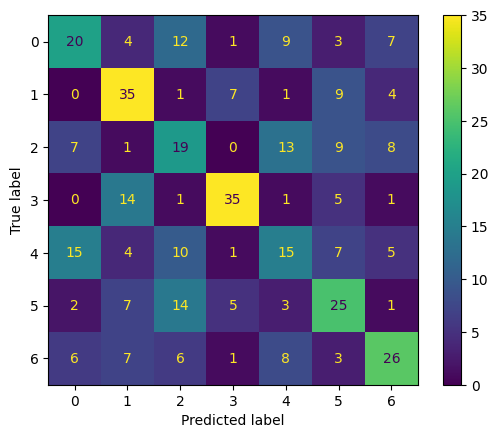

In [31]:
plt.figure(figsize=(8,8))
ConfusionMatrixDisplay.from_predictions(df_val.target,np.argmax(preds_val,axis=1))
plt.savefig(f"val_conf_matrix.png", format="png")
plt.show();

In [32]:
conf = wandb.Image(data_or_path="val_conf_matrix.png")
wandb.log({"val_conf_matrix": conf})

In [33]:
submission = pd.read_csv("/kaggle/input/h2oai-predict-the-llm/sample_submission.csv",index_col="id")
submission[:] = preds
submission.to_csv("submission.csv")
display(submission)

,target_0,target_1,target_2,target_3,target_4,target_5,target_6
id,,,,,,,
0,0.537203,0.005308,0.265919,0.002646,0.135906,0.035637,0.017381
1,0.873631,0.032624,0.037906,0.003947,0.018644,0.020409,0.012839
2,0.004528,0.012757,0.016562,0.006451,0.004655,0.951346,0.003701
3,0.211084,0.022861,0.142369,0.007296,0.081313,0.023146,0.511930
4,0.002137,0.110527,0.005598,0.865259,0.001065,0.009779,0.005635
...,...,...,...,...,...,...,...
996,0.081586,0.207556,0.191470,0.070641,0.055888,0.208285,0.184576
997,0.006006,0.749369,0.041133,0.103533,0.003433,0.069279,0.027248
998,0.135472,0.153201,0.113756,0.011189,0.030837,0.118990,0.436555


In [34]:
tbl_submission = wandb.Table(data=submission.reset_index())
wandb.log({"tbl_submission_test": tbl_submission})


In [35]:
wandb.finish()

wandb: WARNING Source type is set to 'artifact' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


eval/loss,▃▁▁▅█
eval/runtime,▆▆█▂▁
eval/samples_per_second,▃▃▁▇█
eval/steps_per_second,▄▃▁▇█
train/epoch,▁▁▃▃▄▄▆▆███
train/global_step,▁▁▃▃▅▅▆▆█████
train/learning_rate,█▆▅▃▁
train/loss,█▆▄▂▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁
